# CT CV Scans

## Установка библиотек

In [1]:
%pip install numpy pandas nibabel torch torchvision scikit-learn opencv-python

Note: you may need to restart the kernel to use updated packages.


## Импорт библиотек

In [2]:
from dataclasses import dataclass
import glob
import json
import math
import os
import random
import time
from typing import Dict, List, Optional, Tuple

import cv2
import nibabel as nib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torch.amp import autocast, GradScaler

## Подготовка датасета

### Назначение переменных

In [3]:
# Указание директорий
base_dir = "data/COVID19_1110/studies"  # корень с папками CT-0..CT-4
out_manifest_path = "data/manifest.csv" # куда сохранить manifest.csv

# Описание: бинарное кодирование классов для задачи CT-0 (норма) против CT-1..4 (патология)
# Объект: classes (dict[str,int])
# Функционал: соответствие названия папки классу метки (0=норма, 1=патология)
# Обоснование: объединяем CT-1..4 в один положительный класс, чтобы увеличить обучающую выборку и
#              учесть различные степени поражения как единый «патологический» класс для бинарной модели
classes = {
    "CT-0": 0,  # норма
    "CT-1": 1,  # патология
    "CT-2": 1,  # патология
    "CT-3": 1,  # патология
    "CT-4": 1,  # патология
}

# Описание: целевое отношение количества CT-0 к сумме CT-1..4 в TRAIN после оверсемплинга
# Объект: target_ct0_to_pos_ratio (Optional[float])
# Функционал: если задано, увеличиваем (дублируем с заменой) CT-0 в TRAIN, чтобы не меньше заданного ratio
# Обоснование: явное усиление представления нормы для борьбы с дисбалансом
target_ct0_to_pos_ratio = 3.0

# Описание: множитель увеличения размера TRAIN
# Объект: train_size_multiplier (float)
# Функционал: после базового стратифицированного сплита увеличиваем TRAIN примерно в train_size_multiplier раз
# Обоснование: удваиваем обучающую выборку без утечки в val/test
train_size_multiplier = 2.0

# Сплиты (сумма ≈ 1.0)
split_cfg = {"train": 0.70, "val": 0.15, "test": 0.15}

# Seed
seed = 42

### Сканирование папок и сбор таблицы

In [4]:
rows = []
for cname, label in classes.items():
    folder_path = os.path.join(base_dir, cname)
    nii_files = sorted(glob.glob(os.path.join(folder_path, "*.nii.gz")))
    for path in nii_files:
        study_id = os.path.basename(path).replace(".nii.gz", "")
        rows.append({"study_id": study_id, "path": os.path.abspath(path), "label": int(label), "class": cname})
df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError("Не найдено ни одного .nii.gz в указанных папках.")
print("Всего серий:", len(df))
display(df.groupby(["class","label"]).size().to_frame("count"))

Всего серий: 1110


,,count
class,label,
CT-0,0,254
CT-1,1,684
CT-2,1,125
CT-3,1,45
CT-4,1,2


### (Опционально) Ограничение количества CT-0 под заданное соотношение

In [5]:
# Описание: подготовка базового набора (до сплитов) для CT-0 vs CT-1..4
# Объекты: df_neg (CT-0), df_pos (CT-1..4), df_base (объединение)
# Функционал: формируем бинарный датасет без изменения количества; балансировку и удвоение делаем ПОСЛЕ сплитов
# Обоснование: избегаем утечки и искажения валидации/теста

df_neg = df[df["label"] == 0].copy()   # CT-0
df_pos = df[df["label"] == 1].copy()   # CT-1..4

# Базовый пул без пред-обрезки, просто перемешаем
df_base = pd.concat([df_neg, df_pos], axis=0).sample(frac=1.0, random_state=seed).reset_index(drop=True)
print("Базовый пул серий:", len(df_base))
display(df_base.groupby(["class","label"]).size().to_frame("count"))

Базовый пул серий: 1110


,,count
class,label,
CT-0,0,254
CT-1,1,684
CT-2,1,125
CT-3,1,45
CT-4,1,2


In [ ]:
# Описание: ограничение общего числа серий до max_total_series с сохранением распределения классов
# Объекты: max_total_series (int), df_base (pd.DataFrame после сэмплинга)
# Функционал: если базовый пул превышает лимит, берём стратифицированную подвыборку по 'label' размером max_total_series
# Обоснование: ограничиваем объём данных для ускорения экспериментов, сохраняя честный split и баланс классов

max_total_series = 300

if len(df_base) > max_total_series:
    df_base, _ = train_test_split(
        df_base,
        train_size=max_total_series,
        stratify=df_base["label"],
        random_state=seed
    )
    df_base = df_base.reset_index(drop=True)

print("После ограничения базового пула:", len(df_base))
display(df_base.groupby(["class","label"]).size().to_frame("count"))


После ограничения базового пула: 300


,,count
class,label,
CT-0,0,69
CT-1,1,186
CT-2,1,36
CT-3,1,8
CT-4,1,1


### Стратифицированный split 70/15/15 по классам

In [7]:
# Описание: стратифицированный split 70/15/15 без утечек
# Объекты: train, val, test (pd.DataFrame)
# Функционал: сначала сплитим базовый пул; затем делаем БАЛАНСИРОВКУ ТОЛЬКО В TRAIN
# Обоснование: сохраняем честность оценки на val/test

# Отделение test
test_size = split_cfg["test"]
trainval, test = train_test_split(
    df_base, test_size=test_size, stratify=df_base["label"], random_state=seed
)

# Разделение train и val
val_frac_of_trainval = split_cfg["val"] / (split_cfg["train"] + split_cfg["val"])
train, val = train_test_split(
    trainval, test_size=val_frac_of_trainval, stratify=trainval["label"], random_state=seed
)

# --- Балансировка и УВЕЛИЧЕНИЕ TRAIN ---
# Описание: оверсемплинг CT-0 и общее масштабирование до ~train_size_multiplier
# Объект: train_bal (pd.DataFrame)
# Функционал:
#   1) доводим отношение CT-0:POS не ниже target_ct0_to_pos_ratio
#   2) затем масштабируем train до целевого размера без изменения val/test
neg_train = train[train["label"] == 0]
pos_train = train[train["label"] == 1]

# 1) Оверсемплинг CT-0 до целевого соотношения
if target_ct0_to_pos_ratio is not None and len(pos_train) > 0:
    want_neg = int(math.ceil(len(pos_train) * float(target_ct0_to_pos_ratio)))
    if len(neg_train) < want_neg:
        add_cnt = want_neg - len(neg_train)
        neg_extra = neg_train.sample(n=add_cnt, replace=True, random_state=seed)
        neg_train = pd.concat([neg_train, neg_extra], axis=0)

train_bal = pd.concat([neg_train, pos_train], axis=0).sample(frac=1.0, random_state=seed).reset_index(drop=True)

# 2) Масштабирование train до k раз (приближённо)
if train_size_multiplier is not None and train_size_multiplier > 1.0:
    target_size = int(math.ceil(len(train) * float(train_size_multiplier)))
    if len(train_bal) < target_size:
        add_cnt = target_size - len(train_bal)
        train_extra = train_bal.sample(n=add_cnt, replace=True, random_state=seed)
        train_bal = pd.concat([train_bal, train_extra], axis=0).sample(frac=1.0, random_state=seed).reset_index(drop=True)

# проставляем split
train_bal["split"] = "train"
val["split"] = "val"
test["split"] = "test"

manifest = pd.concat([train_bal, val, test], axis=0).reset_index(drop=True)
manifest = manifest[["study_id","path","label","split"]]

print("Распределение по split и классу:")
display(manifest.groupby(["split","label"]).size().to_frame("count"))

Распределение по split и классу:


count
split label       
test  0         10
      1         35
train 0        483
      1        161
val   0         10
      1         35

### Сохранение `manifest.csv`

In [8]:
# Описание: сохранение и базовая проверка совместимости
# Объект: manifest.csv
# Функционал: сохраняем CSV и проверяем, что downstream-ячейки ожидают те же колонки/пути
# Обоснование: после изменения классов/баланса важно сохранить формат интерфейса
os.makedirs(os.path.dirname(out_manifest_path), exist_ok=True)
manifest.to_csv(out_manifest_path, index=False)
print("Сохранено:", out_manifest_path)
assert set(manifest.columns) >= {"study_id","path","label","split"}
print("Колонки манифеста:", list(manifest.columns))
manifest.head()

Сохранено: data/manifest.csv
Колонки манифеста: ['study_id', 'path', 'label', 'split']


,study_id,path,label,split
0,study_0653,/home/mikame/Рабочий стол/CV_CT_scans/data/COV...,1,train
1,study_0565,/home/mikame/Рабочий стол/CV_CT_scans/data/COV...,1,train
2,study_0522,/home/mikame/Рабочий стол/CV_CT_scans/data/COV...,1,train
3,study_0027,/home/mikame/Рабочий стол/CV_CT_scans/data/COV...,0,train
4,study_0179,/home/mikame/Рабочий стол/CV_CT_scans/data/COV...,0,train


## Функции и переменные для обучения и оценки

### Конфиг и random seed

In [9]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

DEVICE = torch.device("cuda")
torch.backends.cudnn.benchmark = True
print("Device:", DEVICE)

Device: cuda


### HU-окна и утилиты

In [10]:
WINDOWS = {
    "lung": (-1000.0, 400.0),
    "mediastinal": (-150.0, 250.0),
    "soft": (-300.0, 300.0),
}

def apply_window(hu: np.ndarray, window: Tuple[float, float]) -> np.ndarray:
    wl, wh = window
    x = np.clip(hu, wl, wh)
    x = (x - wl) / (wh - wl + 1e-6)
    return x.astype(np.float32)

def resize_to_square(img: np.ndarray, out: int) -> np.ndarray:
    return cv2.resize(img, (out, out), interpolation=cv2.INTER_AREA)

def reflect_indices(center: int, half: int, max_idx: int) -> List[int]:
    idxs = []
    for d in range(-half, half + 1):
        z = center + d
        if z < 0:
            z = -z
        if z > max_idx:
            z = max_idx - (z - max_idx)
        z = int(np.clip(z, 0, max_idx))
        idxs.append(z)
    return idxs

def load_nii(path: str) -> np.ndarray:
    img = nib.load(path)
    vol = img.get_fdata().astype(np.float32)
    return vol  # H x W x Z

def volume_to_hu(vol: np.ndarray, slope: float = 1.0, intercept: float = 0.0) -> np.ndarray:
    return vol * slope + intercept

### Конфиги пакетизации и аугментаций

In [11]:
@dataclass
class PackConfig:
    k: int = 5
    stride_train: int = 3
    stride_eval: int = 2
    z_crop_ratio: float = 0.8
    img_size: int = 320
    windows: List[str] = None
    def __post_init__(self):
        if self.windows is None:
            self.windows = ["lung", "mediastinal"]

@dataclass
class AugConfig:
    hflip_p: float = 0.5
    jitter_p: float = 0.3
    jitter_brightness: float = 0.10
    jitter_contrast: float = 0.10

### Датасет 2.5D

In [12]:
class CT25DDataset(Dataset):
    def __init__(self, manifest_csv: str, split: str, pack: PackConfig,
                 aug: Optional[AugConfig] = None, max_packs_per_series: Optional[int] = None, seed: int = 42):
        super().__init__()
        self.pack = pack
        self.aug = aug
        self.rng = np.random.default_rng(seed)

        df = pd.read_csv(manifest_csv)
        assert set(df.columns) >= {"study_id", "path", "label", "split"}
        self.df = df[df["split"] == split].reset_index(drop=True)

        self.index = []
        for i, row in self.df.iterrows():
            p = row["path"]
            if not os.path.isfile(p):
                continue
            try:
                vol = load_nii(p)
            except Exception:
                continue
            H, W, Z = vol.shape
            z0 = int((1.0 - self.pack.z_crop_ratio) / 2.0 * Z)
            z1 = int(Z - z0)
            z_range = list(range(z0, z1))
            stride = self.pack.stride_train if split == "train" else self.pack.stride_eval
            z_idxs = z_range[::stride]

            if split == "train" and max_packs_per_series is not None and len(z_idxs) > max_packs_per_series:
                z_idxs = list(self.rng.choice(z_idxs, size=max_packs_per_series, replace=False))

            for z in z_idxs:
                self.index.append((i, z))

        self.series_labels = self.df["label"].astype(int).values

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx: int):
        series_idx, z_anchor = self.index[idx]
        row = self.df.iloc[series_idx]
        path = row["path"]
        label = int(row["label"])

        vol = load_nii(path)
        vol = volume_to_hu(vol)
        H, W, Z = vol.shape

        k = self.pack.k
        half = k // 2
        z_ids = reflect_indices(z_anchor, half, Z - 1)

        chans = []
        for zn in z_ids:
            slc = vol[:, :, zn]
            slc = resize_to_square(slc, self.pack.img_size)
            for wname in self.pack.windows:
                chans.append(apply_window(slc, WINDOWS[wname]))

        c = np.stack(chans, axis=0)

        if self.aug is not None and row["split"] == "train":
            if np.random.rand() < self.aug.hflip_p:
                c = c[:, :, ::-1]
            if np.random.rand() < self.aug.jitter_p:
                b = self.aug.jitter_brightness
                g = 1.0 + self.aug.jitter_contrast * (np.random.rand() * 2 - 1)
                add = b * (np.random.rand() * 2 - 1)
                c = np.clip(c * g + add, 0.0, 1.0)

        x = torch.from_numpy(c.copy())
        y = torch.tensor([label], dtype=torch.float32)
        sid = row["study_id"]
        return {"image": x, "label": y, "study_id": sid, "z": z_anchor, "series_idx": series_idx}

## Обучение и оценка моделей

### Вариант 1: ResNet multi-channel

In [13]:
class ResNetMultiIn(nn.Module):
    def __init__(self, base: str = "resnet18", in_ch: int = 10, pretrained: bool = True):
        super().__init__()
        if base == "resnet18":
            net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
            feat_dim = 512
        elif base == "resnet50":
            net = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
            feat_dim = 2048
        else:
            raise ValueError("base must be resnet18 or resnet50")

        old_conv = net.conv1
        net.conv1 = nn.Conv2d(in_ch, old_conv.out_channels, kernel_size=old_conv.kernel_size,
                              stride=old_conv.stride, padding=old_conv.padding, bias=False)
        nn.init.kaiming_normal_(net.conv1.weight, mode='fan_out', nonlinearity='relu')

        self.backbone = nn.Sequential(
            net.conv1, net.bn1, net.relu, net.maxpool,
            net.layer1, net.layer2, net.layer3, net.layer4
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.head = nn.Linear(feat_dim, 1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x).flatten(1)
        x = self.head(x)
        return x

### Вариант 2: ResNet + 1×1 channel squeeze

In [14]:
class ResNetWithSqueeze(nn.Module):
    def __init__(self, base: str = "resnet18", in_ch: int = 10, squeeze_ch: int = 3, pretrained: bool = True):
        super().__init__()
        self.squeeze = nn.Sequential(
            nn.Conv2d(in_ch, squeeze_ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(squeeze_ch),
            nn.ReLU(inplace=True),
        )
        if base == "resnet18":
            net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
            feat_dim = 512
        elif base == "resnet50":
            net = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
            feat_dim = 2048
        else:
            raise ValueError("base must be resnet18 or resnet50")

        old_conv = net.conv1
        net.conv1 = nn.Conv2d(squeeze_ch, old_conv.out_channels, kernel_size=old_conv.kernel_size,
                              stride=old_conv.stride, padding=old_conv.padding, bias=False)
        nn.init.kaiming_normal_(net.conv1.weight, mode='fan_out', nonlinearity='relu')

        self.backbone = nn.Sequential(
            net.conv1, net.bn1, net.relu, net.maxpool,
            net.layer1, net.layer2, net.layer3, net.layer4
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.head = nn.Linear(feat_dim, 1)

    def forward(self, x):
        x = self.squeeze(x)
        x = self.backbone(x)
        x = self.pool(x).flatten(1)
        x = self.head(x)
        return x

### Вариант 3: ResNet + channel-attention

In [15]:
class ChannelAttention(nn.Module):
    def __init__(self, in_ch: int, reduction: int = 8):
        super().__init__()
        hidden = max(1, in_ch // reduction)
        self.mlp = nn.Sequential(
            nn.Linear(in_ch, hidden, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, in_ch, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, h, w = x.shape
        gap = x.mean(dim=(2,3))  # BxC
        wgt = self.mlp(gap)      # BxC
        wgt = wgt.view(b, c, 1, 1)
        return x * wgt

class ResNetWithChAttn(nn.Module):
    def __init__(self, base: str = "resnet18", in_ch: int = 10, pretrained: bool = True):
        super().__init__()
        if base == "resnet18":
            net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
            feat_dim = 512
        elif base == "resnet50":
            net = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
            feat_dim = 2048
        else:
            raise ValueError("base must be resnet18 or resnet50")

        old_conv = net.conv1
        net.conv1 = nn.Conv2d(in_ch, old_conv.out_channels, kernel_size=old_conv.kernel_size,
                              stride=old_conv.stride, padding=old_conv.padding, bias=False)
        nn.init.kaiming_normal_(net.conv1.weight, mode='fan_out', nonlinearity='relu')

        self.attn = ChannelAttention(in_ch)
        self.backbone = nn.Sequential(
            net.conv1, net.bn1, net.relu, net.maxpool,
            net.layer1, net.layer2, net.layer3, net.layer4
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.head = nn.Linear(feat_dim, 1)

    def forward(self, x):
        x = self.attn(x)
        x = self.backbone(x)
        x = self.pool(x).flatten(1)
        x = self.head(x)
        return x

### Загрузка и критерий потерь

In [16]:
def make_loaders(manifest: str, pack: PackConfig, aug: AugConfig,
                 batch_size: int = 16, workers: int = 8,
                 max_packs_per_series_train: Optional[int] = 12):
    ds_train = CT25DDataset(manifest, split="train", pack=pack, aug=aug,
                            max_packs_per_series=max_packs_per_series_train)
    ds_val = CT25DDataset(manifest, split="val", pack=pack, aug=None)

    y_series = ds_train.series_labels
    n_pos = int((y_series == 1).sum())
    n_neg = int((y_series == 0).sum())
    pos_weight = torch.tensor([max(1.0, n_neg / max(1, n_pos))], dtype=torch.float32)

    print(f"Train series: pos={n_pos}, neg={n_neg}, pos_weight={pos_weight.item():.2f}")

    loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True, persistent_workers=(workers>0), prefetch_factor=4)
    loader_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, persistent_workers=(workers>0), prefetch_factor=4)
    return ds_train, ds_val, loader_train, loader_val, pos_weight

class WarmupCosine:
    def __init__(self, optimizer, warmup_steps: int, total_steps: int, base_lr: float):
        self.opt = optimizer
        self.warm = warmup_steps
        self.total = total_steps
        self.base_lr = base_lr
        self.t = 0
    def step(self):
        self.t += 1
        if self.t <= self.warm:
            lr = self.base_lr * self.t / max(1, self.warm)
        else:
            t = self.t - self.warm
            T = max(1, self.total - self.warm)
            lr = 0.5 * self.base_lr * (1 + math.cos(math.pi * t / T))
        for pg in self.opt.param_groups: pg["lr"] = lr
        return lr

### Функция обучения

In [17]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    loss_sum = 0.0
    n = 0
    for batch in loader:
        x = batch["image"].to(device, non_blocking=True)
        y = batch["label"].to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        n += x.size(0)
    return loss_sum / max(1, n)

### Инференс и агрегация (top-k mean)

In [18]:
def aggregate_series(scores, topk_ratio: float = 0.1):
    if len(scores) == 0: return 0.0
    import numpy as np, math
    k = max(1, int(math.ceil(len(scores) * topk_ratio)))
    topk = sorted(scores, reverse=True)[:k]
    return float(np.mean(topk))

@torch.no_grad()
def eval_series(model, loader, device, topk_ratio: float = 0.1):
    model.eval()
    by_series = {}
    for batch in loader:
        x = batch["image"].to(device, non_blocking=True)
        logits = model(x)
        probs = torch.sigmoid(logits).squeeze(1).cpu().numpy()
        sids = batch["study_id"]
        ys = batch["label"].squeeze(1).cpu().numpy().astype(int)
        for p, sid, y in zip(probs, sids, ys):
            if sid not in by_series:
                by_series[sid] = {"scores": [], "label": int(y)}
            by_series[sid]["scores"].append(float(p))

    import numpy as np
    y_true, y_pred = [], []
    for sid, rec in by_series.items():
        agg = aggregate_series(rec["scores"], topk_ratio=topk_ratio)
        y_pred.append(agg)
        y_true.append(rec["label"])
    return np.array(y_true), np.array(y_pred)

### Метрики: accuracy / precision / recall / F1 / ROC-AUC

In [19]:
def binarize(y_prob: np.ndarray, thr: float = 0.5) -> np.ndarray:
    return (y_prob >= thr).astype(int)

def find_best_threshold(y_true: np.ndarray, y_prob: np.ndarray, metric: str = "f1") -> Tuple[float, float]:
    thr_grid = np.linspace(0.05, 0.95, 181)
    best_thr, best_val = 0.5, -1.0
    for thr in thr_grid:
        y_pred = (y_prob >= thr).astype(int)
        if metric == "f1":
            val = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)[2]
        elif metric == "accuracy":
            val = accuracy_score(y_true, y_pred)
        else:
            raise ValueError("metric must be 'f1' or 'accuracy'")
        if val > best_val:
            best_val, best_thr = val, thr
    return best_thr, best_val

def metrics_report(y_true: np.ndarray, y_prob: np.ndarray, thr: float = 0.5):
    y_pred = binarize(y_prob, thr)
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    try:
        roc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else float("nan")
    except Exception:
        roc = float("nan")

    print("Confusion matrix (series-level):")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification report (series-level):")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))

    return {"accuracy": float(acc), "precision": float(precision), "recall": float(recall), "f1": float(f1), "roc_auc": float(roc)}

# Пайплайн

In [20]:
# Описание: подбор порога для двухэтапного каскада
# Объект: find_best_threshold_cascade(y_true, y_prob, is_norm_flag, metric)
# Функционал: подбирает порог только для подозрительных случаев (is_norm_flag==0),
#             нормам (is_norm_flag==1) всегда предсказывает 0; оптимизирует F1/accuracy
# Обоснование: корректная оптимизация метрик в двухэтапной схеме без влияния на класс нормы
import numpy as np
from typing import Tuple
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def find_best_threshold_cascade(y_true: np.ndarray, y_prob: np.ndarray, is_norm_flag: np.ndarray, metric: str = "f1") -> Tuple[float, float]:
    thr_grid = np.linspace(0.05, 0.95, 181)
    best_thr, best_val = 0.5, -1.0
    for thr in thr_grid:
        y_pred_tmp = np.where(is_norm_flag == 1, 0, (y_prob >= thr).astype(int))
        if metric == "f1":
            val = precision_recall_fscore_support(y_true, y_pred_tmp, average="binary", zero_division=0)[2]
        elif metric == "accuracy":
            val = accuracy_score(y_true, y_pred_tmp)
        else:
            raise ValueError("metric must be 'f1' or 'accuracy'")
        if val > best_val:
            best_val, best_thr = float(val), float(thr)
    return best_thr, best_val


In [21]:
# Описание: Двуэтапный пайплайн (Mahalanobis-фильтр «норма/аномалия» + классификатор)
# Объекты: SETTINGS (dict)
# Функционал: конфигурация путей, порогов и целевой специфичности для нормы
# Обоснование: хотим минимизировать FP по норме — сначала жёстко отсекаем норму статистическим
#              фильтром на эмбеддингах, затем классифицируем оставшиеся случаи моделью
SETTINGS = {
    "manifest_candidates": [
        # приоритет: ранее сохранённый в ноутбуке путь
        globals().get("out_manifest_path", None),
        "/home/mikame/Рабочий стол/CV_CT_scans/data/manifest.csv",
        "data/manifest.csv",
    ],
    "out_dir": "/home/mikame/Рабочий стол/CV_CT_scans/runs/exp_notebook/two_stage",
    "topk_ratio": 0.10,         # агрегация для этапа классификатора
    "cls_threshold": 0.830,     # порог классификатора (ResNetWithChAttn)
    "target_specificity": 0.99, # желаемая специфичность фильтра нормы
    "eps_cov": 1e-3,            # регуляризация ковариации
}

import os, math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score

os.makedirs(SETTINGS["out_dir"], exist_ok=True)

# Описание: выбор актуального manifest.csv
# Объект: MANIFEST_PATH (str)
# Функционал: находит первый существующий путь из кандидатов
# Обоснование: обеспечить работу ячейки независимо от порядка исполнения предыдущих
candidates = [p for p in SETTINGS["manifest_candidates"] if isinstance(p, str)]
MANIFEST_PATH = next((p for p in candidates if os.path.isfile(p)), None)
if MANIFEST_PATH is None:
    raise FileNotFoundError("Не найден manifest.csv среди кандидатов. Сгенерируйте manifest перед запуском двуэтапного пайплайна.")

# Описание: загрузка модели и вычисление числа входных каналов
# Объекты: DEVICE (torch.device), pack (PackConfig), in_ch (int), model (ResNetWithChAttn)
# Функционал: инициализация модели и согласование числа входных каналов с pack/windows
# Обоснование: корректное соответствие архитектуры и датасета
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if 'preset' in globals():
    pack = PackConfig(k=preset.get("k", 5), img_size=preset.get("img_size", 320), windows=preset.get("windows", ["lung","mediastinal"]))
else:
    pack = PackConfig(k=5, img_size=320, windows=["lung","mediastinal"])
pack.stride_eval = 2
in_ch = len(pack.windows) * pack.k

model = ResNetWithChAttn(base="resnet18", in_ch=in_ch, pretrained=False).to(DEVICE)
ckpt_path_candidates = [
    "/home/mikame/Рабочий стол/CV_CT_scans/runs/exp_balanced/ResNetWithChAttn/best.pt",
    "/home/mikame/Рабочий стол/CV_CT_scans/runs Done/exp_balanced/ResNetWithChAttn/best.pt",
]
_ck = next((p for p in ckpt_path_candidates if os.path.isfile(p)), None)
if _ck is None:
    raise FileNotFoundError("Не найден чекпойнт ResNetWithChAttn/best.pt в ожидаемых путях.")
state = torch.load(_ck, map_location="cpu")
model.load_state_dict(state["model"], strict=True)
model.eval()

# Описание: функции экстракции эмбеддингов серии
# Объекты: forward_features (callable), extract_series_features (callable)
# Функционал: получить эмбеддинги перед головой (avgpool-выход) и усреднить по пакетам в серии
# Обоснование: статистический фильтр работает на устойчивых признаках серии
@torch.no_grad()
def forward_features(model: nn.Module, x: torch.Tensor) -> torch.Tensor:
    # совместимо с ResNetWithChAttn из ноутбука
    y = model.attn(x)
    y = model.backbone(y)
    y = model.pool(y).flatten(1)
    return y

@torch.no_grad()
def extract_series_features(model: nn.Module, dataset_csv: str, split: str, pack: PackConfig, batch_size: int = 16, workers: int = 8):
    ds = CT25DDataset(dataset_csv, split=split, pack=pack, aug=None)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True,
                        persistent_workers=(workers>0), prefetch_factor=4)
    by_series = {}
    for batch in loader:
        x = batch["image"].to(DEVICE, non_blocking=True)
        feats = forward_features(model, x).cpu().numpy()  # B x D
        sids = batch["study_id"]
        ys = batch["label"].squeeze(1).cpu().numpy().astype(int)
        for f, sid, y in zip(feats, sids, ys):
            if sid not in by_series:
                by_series[sid] = {"feats": [], "label": int(y)}
            by_series[sid]["feats"].append(f)
    # усреднение по пакетам
    X, y, sids = [], [], []
    for sid, rec in by_series.items():
        F = np.stack(rec["feats"], axis=0)
        X.append(F.mean(axis=0))
        y.append(rec["label"])
        sids.append(sid)
    return np.asarray(X, dtype=np.float32), np.asarray(y, dtype=int), sids

# Описание: Mahalanobis-модель нормы
# Объекты: fit_mahalanobis (callable)
# Функционал: оценить μ и Σ по нормам (label=0), вернуть параметры и калиброванный порог по специфичности
# Обоснование: контролируем FP по норме фиксируя целевую специфичность
def fit_mahalanobis(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, target_spec: float, eps: float = 1e-3):
    Xn = X_train[y_train == 0]
    if Xn.shape[0] < 2:
        raise RuntimeError("Слишком мало норм для оценки ковариации.")
    mu = Xn.mean(axis=0)
    C = np.cov(Xn, rowvar=False)
    D = C.shape[0]
    C = C + eps * np.eye(D, dtype=np.float32)
    Cinv = np.linalg.inv(C)
    # дистанции на валидации по нормам
    def maha(x):
        d = x - mu
        return np.sqrt(np.einsum('...i,ij,...j->...', d, Cinv, d))
    d_val_norm = maha(X_val[y_val == 0])
    q = np.clip(target_spec, 0.5, 0.9999)
    thr = np.quantile(d_val_norm, q)
    return mu.astype(np.float32), Cinv.astype(np.float32), float(thr), maha

# Описание: каскадная оценка серии (фильтр нормы + классификатор)
# Объекты: cascade_eval (callable)
# Функционал: сначала решаем «норма?» по Mahalanobis; если нет — считаем prob классификатором и решаем по порогу
# Обоснование: приоритизируем специфичность по норме, сокращая FP
@torch.no_grad()
def cascade_eval(model: nn.Module, manifest_csv: str, split: str, pack: PackConfig,
                 mu: np.ndarray, Cinv: np.ndarray, thr_norm: float, maha_fn, topk_ratio: float, cls_thr: float):
    # 1) признаки и дистанции
    X, y, sids = extract_series_features(model, manifest_csv, split, pack)
    d = maha_fn(X)
    is_normal = d <= thr_norm
    # 2) вероятности классификатора для всех (проще один прогон) и выбор для подозрительных
    ds = CT25DDataset(manifest_csv, split=split, pack=pack, aug=None)
    loader = DataLoader(ds, batch_size=16, shuffle=False, num_workers=8, pin_memory=True,
                        persistent_workers=True, prefetch_factor=4)
    y_true, y_prob = eval_series(model, loader, DEVICE, topk_ratio=topk_ratio)
    # сводим в одну таблицу
    sid_to_prob = {sid: p for sid, p in zip(sids, y_prob)}
    y_pred = []
    probs_used = []
    for sid, flag_norm in zip(sids, is_normal):
        if flag_norm:
            y_pred.append(0)
            probs_used.append(sid_to_prob.get(sid, 0.0))
        else:
            p = sid_to_prob.get(sid, 0.0)
            y_pred.append(1 if p >= cls_thr else 0)
            probs_used.append(p)
    y_pred = np.asarray(y_pred, dtype=int)
    probs_used = np.asarray(probs_used, dtype=np.float32)
    return sids, y_true, probs_used, d, is_normal.astype(int), y_pred

# Описание: процедура обучения фильтра и каскадной валидации
# Объекты: df_summary (pd.DataFrame)
# Функционал: обучает Mahalanobis на train-нормах, калибрует на val-нормах, оценивает каскад на val
# Обоснование: полностью воспроизводимый pipeline
from sklearn.model_selection import train_test_split

def run_two_stage_pipeline():
    # 1) лоадеры train/val (как в обучении)
    aug = AugConfig()
    ds_train, ds_val, loader_train, loader_val, _ = make_loaders(MANIFEST_PATH, pack, aug, batch_size=16, workers=8, max_packs_per_series_train=12)

    # 2) эмбеддинги train/val
    X_tr, y_tr, sids_tr = extract_series_features(model, MANIFEST_PATH, split="train", pack=pack)
    X_va, y_va, sids_va = extract_series_features(model, MANIFEST_PATH, split="val", pack=pack)

    # 3) подгонка Mahalanobis и порога под целевую специфичность по вал-нормам
    mu, Cinv, thr_norm, maha_fn = fit_mahalanobis(X_tr, y_tr, X_va, y_va, SETTINGS["target_specificity"], SETTINGS["eps_cov"])

    # 4) каскад на валидации
    sids, y_true, y_prob, d_maha, is_norm_flag, y_pred = cascade_eval(
        model, MANIFEST_PATH, split="val", pack=pack,
        mu=mu, Cinv=Cinv, thr_norm=thr_norm, maha_fn=maha_fn,
        topk_ratio=SETTINGS["topk_ratio"], cls_thr=SETTINGS["cls_threshold"]
    )

    # 4.1) подбор порога для классификатора в каскаде по F1 на валидации
    best_thr, best_val = find_best_threshold_cascade(y_true, y_prob, is_norm_flag, metric="f1")
    y_pred = np.where(is_norm_flag == 1, 0, (y_prob >= best_thr).astype(int))

    # 5) метрики и сохранение
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan
    except Exception:
        auc = np.nan

    df_out = pd.DataFrame({
        "study_id": sids,
        "true": y_true,
        "prob_cls": y_prob,
        "dist_maha": d_maha,
        "pred": y_pred,
        "stage1_is_norm": is_norm_flag,
    })
    out_csv = os.path.join(SETTINGS["out_dir"], "two_stage_val_series.csv")
    df_out.to_csv(out_csv, index=False)

    # краткий отчёт
    print("Confusion matrix (cascade, val) rows=true, cols=pred:\n", cm)
    print(f"[Cascade] Tuned threshold on val (F1): {best_thr:.3f} -> F1={best_val:.4f}")
    print(f"Precision={prec:.3f} Recall={rec:.3f} F1={f1:.3f} AUC={auc if not (isinstance(auc, float) and math.isnan(auc)) else 'nan'}")
    print(f"Calibrated norm threshold (Mahalanobis) @spec={SETTINGS['target_specificity']:.3f}: {thr_norm:.4f}")
    print("Saved:", out_csv)

# Запуск пайплайна (можно переисполнить)
run_two_stage_pipeline()


Train series: pos=161, neg=483, pos_weight=3.00
Confusion matrix (cascade, val) rows=true, cols=pred:
 [[10  0]
 [29  6]]
[Cascade] Tuned threshold on val (F1): 0.180 -> F1=0.2927
Precision=1.000 Recall=0.171 F1=0.293 AUC=0.7228571428571429
Calibrated norm threshold (Mahalanobis) @spec=0.990: 55.9918
Saved: /home/mikame/Рабочий стол/CV_CT_scans/runs/exp_notebook/two_stage/two_stage_val_series.csv


## Запуск обучения

In [22]:
manifest_path = out_manifest_path
out_root = "runs/exp_balanced"
os.makedirs(out_root, exist_ok=True)

preset = {
    "base": "resnet18",
    "img_size": 320,
    "k": 5,
    "windows": ["lung", "mediastinal"],
    "batch_size": 16,
    "epochs": 10,
    "lr": 3e-4,
    "wd": 1e-4,
    "warmup_epochs": 1,
    "topk_ratio": 0.1,
    "max_packs_per_series_train": 12,
}

pack = PackConfig(k=preset["k"], img_size=preset["img_size"], windows=preset["windows"])
aug = AugConfig()

ds_train, ds_val, loader_train, loader_val, pos_weight = make_loaders(
    manifest_path, pack, aug,
    batch_size=preset["batch_size"],
    workers=8,
    max_packs_per_series_train=preset["max_packs_per_series_train"]
)

in_ch = len(pack.windows) * pack.k

# Модели
model_factories = {
    "ResNetMultiIn": lambda: ResNetMultiIn(base=preset["base"], in_ch=in_ch, pretrained=True).to(DEVICE),
    "ResNetWithSqueeze": lambda: ResNetWithSqueeze(base=preset["base"], in_ch=in_ch, squeeze_ch=3, pretrained=True).to(DEVICE),
    "ResNetWithChAttn": lambda: ResNetWithChAttn(base=preset["base"], in_ch=in_ch, pretrained=True).to(DEVICE),
}

# Функция обучения и валидации одной модели
def train_and_validate(model_name: str):
    out_dir = os.path.join(out_root, model_name)
    os.makedirs(out_dir, exist_ok=True)

    model = model_factories[model_name]()
    optimizer = torch.optim.AdamW(model.parameters(), lr=preset["lr"], weight_decay=preset["wd"])
    total_steps = preset["epochs"] * max(1, len(loader_train))
    warm_steps = max(1, int(preset["warmup_epochs"] * len(loader_train)))
    sched = WarmupCosine(optimizer, warmup_steps=warm_steps, total_steps=total_steps, base_lr=preset["lr"])
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(DEVICE))

    best_f1 = -1.0
    history = []

    for epoch in range(1, preset["epochs"] + 1):
        t0 = time.time()
        loss_tr = train_one_epoch(model, loader_train, optimizer, loss_fn, DEVICE)
        for _ in range(len(loader_train)):
            sched.step()

        y_true, y_prob = eval_series(model, loader_val, DEVICE, topk_ratio=preset["topk_ratio"])

        # выбрать лучший порог по F1
        best_thr, val_f1 = find_best_threshold(y_true, y_prob, metric="f1")
        dt = time.time() - t0

        history.append({"epoch": epoch, "train_loss": float(loss_tr), "val_f1": float(val_f1), "best_thr": float(best_thr)})
        print(f"[{model_name}] Epoch {epoch:03d} | loss {loss_tr:.4f} | val F1 {val_f1:.4f} @ thr={best_thr:.3f} | {dt:.1f}s")

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save({"model": model.state_dict(), "cfg": preset, "best_thr": float(best_thr)}, os.path.join(out_dir, "best.pt"))
            print(f"[{model_name}]  >> New best F1={best_f1:.4f} (thr={best_thr:.3f}) saved to {out_dir}/best.pt")

    pd.DataFrame(history).to_csv(os.path.join(out_dir, "history.csv"), index=False)
    print(f"[{model_name}] Best F1: {best_f1:.4f}")
    return best_f1

# Запуск обучения для всех моделей
best_scores = {}
for name in model_factories.keys():
    best_scores[name] = train_and_validate(name)

print("Best AUC per model:", best_scores)

Train series: pos=161, neg=483, pos_weight=3.00
[ResNetMultiIn] Epoch 001 | loss 0.9174 | val F1 0.8861 @ thr=0.435 | 498.8s
[ResNetMultiIn]  >> New best F1=0.8861 (thr=0.435) saved to runs/exp_balanced/ResNetMultiIn/best.pt
[ResNetMultiIn] Epoch 002 | loss 0.6271 | val F1 0.8861 @ thr=0.850 | 486.9s
[ResNetMultiIn] Epoch 003 | loss 0.3683 | val F1 0.8947 @ thr=0.875 | 470.1s
[ResNetMultiIn]  >> New best F1=0.8947 (thr=0.875) saved to runs/exp_balanced/ResNetMultiIn/best.pt
[ResNetMultiIn] Epoch 004 | loss 0.1762 | val F1 0.8684 @ thr=0.635 | 495.7s
[ResNetMultiIn] Epoch 005 | loss 0.0990 | val F1 0.8718 @ thr=0.050 | 481.7s
[ResNetMultiIn] Epoch 006 | loss 0.0678 | val F1 0.8718 @ thr=0.425 | 481.4s
[ResNetMultiIn] Epoch 007 | loss 0.0169 | val F1 0.8831 @ thr=0.685 | 482.2s
[ResNetMultiIn] Epoch 008 | loss 0.0082 | val F1 0.8718 @ thr=0.085 | 481.1s
[ResNetMultiIn] Epoch 009 | loss 0.0045 | val F1 0.8831 @ thr=0.535 | 482.8s
[ResNetMultiIn] Epoch 010 | loss 0.0040 | val F1 0.8831 @ t

## Финальные метрики на валидации

In [23]:
results = []
for model_name, factory in [
    ("ResNetMultiIn", model_factories["ResNetMultiIn"]),
    ("ResNetWithSqueeze", model_factories["ResNetWithSqueeze"]),
    ("ResNetWithChAttn", model_factories["ResNetWithChAttn"]),
]:
    out_dir = os.path.join(out_root, model_name)
    best_path = os.path.join(out_dir, "best.pt")
    if not os.path.isfile(best_path):
        print(f"[{model_name}] best.pt not found, skipping")
        continue

    model = factory()
    ckpt = torch.load(best_path, map_location="cpu")
    model.load_state_dict(ckpt["model"])

    y_true, y_prob = eval_series(model, loader_val, DEVICE, topk_ratio=preset["topk_ratio"])
    auc_val = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else float("nan")

    # поиск лучшего порога под F1 (можно сменить на 'accuracy')
    best_thr, best_val = find_best_threshold(y_true, y_prob, metric="f1")
    print(f"[{model_name}] Best threshold (F1) on val: {best_thr:.3f} -> F1={best_val:.4f}")

    report = metrics_report(y_true, y_prob, thr=best_thr)

    # безопасно извлекаем ключевые метрики
    acc = report.get("accuracy")
    prec = report.get("precision")
    rec = report.get("recall")
    f1 = report.get("f1")

    results.append({
        "model": model_name,
        "AUC": float(auc_val) if not np.isnan(auc_val) else None,
        "best_thr": float(best_thr),
        "accuracy": acc if acc is not None else None,
        "precision": prec if prec is not None else None,
        "recall": rec if rec is not None else None,
        "f1": f1 if f1 is not None else None,
    })

df_results = pd.DataFrame(results).sort_values(by="AUC", ascending=False)
print(df_results.to_string(index=False))

# опционально сохраняем
df_results.to_csv(os.path.join(out_root, "summary_metrics.csv"), index=False)

[ResNetMultiIn] Best threshold (F1) on val: 0.875 -> F1=0.8947
Confusion matrix (series-level):
[[ 3  7]
 [ 1 34]]

Classification report (series-level):
              precision    recall  f1-score   support

           0     0.7500    0.3000    0.4286        10
           1     0.8293    0.9714    0.8947        35

    accuracy                         0.8222        45
   macro avg     0.7896    0.6357    0.6617        45
weighted avg     0.8117    0.8222    0.7911        45

[ResNetWithSqueeze] Best threshold (F1) on val: 0.600 -> F1=0.8861
Confusion matrix (series-level):
[[ 1  9]
 [ 0 35]]

Classification report (series-level):
              precision    recall  f1-score   support

           0     1.0000    0.1000    0.1818        10
           1     0.7955    1.0000    0.8861        35

    accuracy                         0.8000        45
   macro avg     0.8977    0.5500    0.5339        45
weighted avg     0.8409    0.8000    0.7296        45

[ResNetWithChAttn] Best threshold 

In [24]:
# Sweep topk_ratio on validation for existing trained models
# - No retraining required; just reload best checkpoints and vary aggregation
# - If sensitivity is more important, consider replacing F1 with F2/target recall

topk_grid = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

from sklearn.metrics import roc_auc_score

def evaluate_model_with_topk(model_name, factory, loader_val, device, topk_grid):
    out_dir = os.path.join(out_root, model_name)
    best_path = os.path.join(out_dir, "best.pt")
    if not os.path.isfile(best_path):
        print(f"[{model_name}] best.pt not found, skipping")
        return None

    model = factory()
    ckpt = torch.load(best_path, map_location="cpu")
    model.load_state_dict(ckpt["model"])

    rows = []
    for tk in topk_grid:
        y_true, y_prob = eval_series(model, loader_val, device, topk_ratio=tk)
        # pick threshold by F1 (swap to recall/F2 if needed)
        best_thr, best_f1 = find_best_threshold(y_true, y_prob, metric="f1")
        auc_val = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else float("nan")
        rep = metrics_report(y_true, y_prob, thr=best_thr)
        rows.append({
            "model": model_name,
            "topk_ratio": tk,
            "best_thr": float(best_thr),
            "F1": float(best_f1),
            "AUC": float(auc_val) if not np.isnan(auc_val) else None,
            "accuracy": rep.get("accuracy"),
            "precision": rep.get("precision"),
            "recall": rep.get("recall"),
        })

    df = pd.DataFrame(rows).sort_values(["model","F1","AUC"], ascending=[True, False, False])
    return df

_results = []
for _model_name, _factory in [
    ("ResNetMultiIn", model_factories["ResNetMultiIn"]),
    ("ResNetWithSqueeze", model_factories["ResNetWithSqueeze"]),
    ("ResNetWithChAttn", model_factories["ResNetWithChAttn"]),
]:
    _df = evaluate_model_with_topk(_model_name, _factory, loader_val, DEVICE, topk_grid)
    if _df is not None:
        display(_df)
        _results.append(_df)

if len(_results):
    df_topk = pd.concat(_results, ignore_index=True)
    print("Лучшие topk_ratio по F1 (валидация):")
    display(df_topk.loc[df_topk.groupby("model")["F1"].idxmax()][["model","topk_ratio","F1","recall","AUC","best_thr"]])



Confusion matrix (series-level):
[[ 2  8]
 [ 1 34]]

Classification report (series-level):
              precision    recall  f1-score   support

           0     0.6667    0.2000    0.3077        10
           1     0.8095    0.9714    0.8831        35

    accuracy                         0.8000        45
   macro avg     0.7381    0.5857    0.5954        45
weighted avg     0.7778    0.8000    0.7552        45

Confusion matrix (series-level):
[[ 3  7]
 [ 1 34]]

Classification report (series-level):
              precision    recall  f1-score   support

           0     0.7500    0.3000    0.4286        10
           1     0.8293    0.9714    0.8947        35

    accuracy                         0.8222        45
   macro avg     0.7896    0.6357    0.6617        45
weighted avg     0.8117    0.8222    0.7911        45

Confusion matrix (series-level):
[[ 2  8]
 [ 1 34]]

Classification report (series-level):
              precision    recall  f1-score   support

           0     0

,model,topk_ratio,best_thr,F1,AUC,accuracy,precision,recall
1,ResNetMultiIn,0.10,0.875,0.894737,0.708571,0.822222,0.829268,0.971429
5,ResNetMultiIn,0.30,0.585,0.883117,0.728571,0.800000,0.809524,0.971429
2,ResNetMultiIn,0.15,0.700,0.883117,0.711429,0.800000,0.809524,0.971429
3,ResNetMultiIn,0.20,0.660,0.883117,0.711429,0.800000,0.809524,0.971429
4,ResNetMultiIn,0.25,0.625,0.883117,0.708571,0.800000,0.809524,0.971429
0,ResNetMultiIn,0.05,0.755,0.883117,0.691429,0.800000,0.809524,0.971429


Confusion matrix (series-level):
[[ 1  9]
 [ 0 35]]

Classification report (series-level):
              precision    recall  f1-score   support

           0     1.0000    0.1000    0.1818        10
           1     0.7955    1.0000    0.8861        35

    accuracy                         0.8000        45
   macro avg     0.8977    0.5500    0.5339        45
weighted avg     0.8409    0.8000    0.7296        45

Confusion matrix (series-level):
[[ 1  9]
 [ 0 35]]

Classification report (series-level):
              precision    recall  f1-score   support

           0     1.0000    0.1000    0.1818        10
           1     0.7955    1.0000    0.8861        35

    accuracy                         0.8000        45
   macro avg     0.8977    0.5500    0.5339        45
weighted avg     0.8409    0.8000    0.7296        45

Confusion matrix (series-level):
[[ 1  9]
 [ 0 35]]

Classification report (series-level):
              precision    recall  f1-score   support

           0     1

,model,topk_ratio,best_thr,F1,AUC,accuracy,precision,recall
5,ResNetWithSqueeze,0.30,0.515,0.886076,0.734286,0.8,0.795455,1.0
4,ResNetWithSqueeze,0.25,0.540,0.886076,0.731429,0.8,0.795455,1.0
3,ResNetWithSqueeze,0.20,0.560,0.886076,0.722857,0.8,0.795455,1.0
2,ResNetWithSqueeze,0.15,0.595,0.886076,0.708571,0.8,0.795455,1.0
1,ResNetWithSqueeze,0.10,0.600,0.886076,0.705714,0.8,0.795455,1.0
0,ResNetWithSqueeze,0.05,0.620,0.886076,0.697143,0.8,0.795455,1.0


Confusion matrix (series-level):
[[ 4  6]
 [ 2 33]]

Classification report (series-level):
              precision    recall  f1-score   support

           0     0.6667    0.4000    0.5000        10
           1     0.8462    0.9429    0.8919        35

    accuracy                         0.8222        45
   macro avg     0.7564    0.6714    0.6959        45
weighted avg     0.8063    0.8222    0.8048        45

Confusion matrix (series-level):
[[ 4  6]
 [ 2 33]]

Classification report (series-level):
              precision    recall  f1-score   support

           0     0.6667    0.4000    0.5000        10
           1     0.8462    0.9429    0.8919        35

    accuracy                         0.8222        45
   macro avg     0.7564    0.6714    0.6959        45
weighted avg     0.8063    0.8222    0.8048        45

Confusion matrix (series-level):
[[ 4  6]
 [ 2 33]]

Classification report (series-level):
              precision    recall  f1-score   support

           0     0

,model,topk_ratio,best_thr,F1,AUC,accuracy,precision,recall
5,ResNetWithChAttn,0.30,0.780,0.891892,0.802857,0.822222,0.846154,0.942857
4,ResNetWithChAttn,0.25,0.810,0.891892,0.800000,0.822222,0.846154,0.942857
3,ResNetWithChAttn,0.20,0.835,0.891892,0.794286,0.822222,0.846154,0.942857
2,ResNetWithChAttn,0.15,0.870,0.891892,0.788571,0.822222,0.846154,0.942857
0,ResNetWithChAttn,0.05,0.950,0.891892,0.777143,0.822222,0.846154,0.942857
1,ResNetWithChAttn,0.10,0.900,0.891892,0.768571,0.822222,0.846154,0.942857


Лучшие topk_ratio по F1 (валидация):


,model,topk_ratio,F1,recall,AUC,best_thr
0,ResNetMultiIn,0.1,0.894737,0.971429,0.708571,0.875
12,ResNetWithChAttn,0.3,0.891892,0.942857,0.802857,0.780
6,ResNetWithSqueeze,0.3,0.886076,1.000000,0.734286,0.515


# Валидация на всём датасете


In [25]:
# Описание: по-групповая валидация CT-1..4 против CT-0
# Объекты: SETTINGS (dict), GROUPS (list[tuple[str,int]])
# Функционал: для каждой группы CT-x собираем манифест (CT-0=0, CT-x=1),
#             считаем инференс ResNetWithChAttn, агрегируем top-k=0.10,
#             бинаризуем порогом 0.830, строим confusion matrix и сохраняем CSV
# Обоснование: оценить метрики отдельно по типам тяжести/патологии

import os, glob
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_fscore_support

SETTINGS = {
    "studies_root": "/home/mikame/Рабочий стол/CV_CT_scans/data/COVID19_1110/studies",
    "out_dir": "/home/mikame/Рабочий стол/CV_CT_scans/runs/exp_notebook/per_group",
    "topk_ratio": 0.10,
    "threshold": 0.830,
}

os.makedirs(SETTINGS["out_dir"], exist_ok=True)

GROUPS = ["CT-1", "CT-2", "CT-3", "CT-4"]

# Проверка доступности чекпойнта
ckpt_path_candidates = [
    "/home/mikame/Рабочий стол/CV_CT_scans/runs/exp_balanced/ResNetWithChAttn/best.pt",
    "/home/mikame/Рабочий стол/CV_CT_scans/runs Done/exp_balanced/ResNetWithChAttn/best.pt",
    "/home/mikame/Рабочий стол/CV_CT_scans/runs/best.pt",
    "/home/mikame/Рабочий стол/CV_CT_scans/runs Done/best.pt",
]
ckpt_path = next((p for p in ckpt_path_candidates if os.path.isfile(p)), None)
if ckpt_path is None:
    raise FileNotFoundError("Не найден best.pt среди ожидаемых путей. Уточните расположение чекпойнта.")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNetWithChAttn(base="resnet18", in_ch=10, pretrained=False).to(DEVICE)
ckpt = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(ckpt["model"], strict=True)
model.eval()

# Общая конфигурация паковки/датасета (как в валидации)
pack = PackConfig(k=5, stride_train=3, stride_eval=2, z_crop_ratio=0.8, img_size=320)

all_rows = []

for grp in GROUPS:
    # Собираем манифест: CT-0 -> label=0, grp -> label=1
    rows = []
    ct0_dir = os.path.join(SETTINGS["studies_root"], "CT-0")
    for p in sorted(glob.glob(os.path.join(ct0_dir, "*.nii.gz"))):
        sid = os.path.splitext(os.path.basename(p))[0]
        rows.append({"study_id": f"CT0::{sid}", "path": p, "label": 0, "split": "val"})
    grp_dir = os.path.join(SETTINGS["studies_root"], grp)
    for p in sorted(glob.glob(os.path.join(grp_dir, "*.nii.gz"))):
        sid = os.path.splitext(os.path.basename(p))[0]
        rows.append({"study_id": f"{grp}::{sid}", "path": p, "label": 1, "split": "val"})

    if len(rows) == 0:
        print(f"[WARN] Группа {grp}: нет данных, пропуск")
        continue

    df_manifest = pd.DataFrame(rows)
    manifest_path = f"/home/mikame/Рабочий стол/CV_CT_scans/data/manifest_{grp}_vs_CT0.csv"
    df_manifest.to_csv(manifest_path, index=False)

    ds_val = CT25DDataset(manifest_path, split="val", pack=pack, aug=None)
    loader_val = DataLoader(ds_val, batch_size=16, shuffle=False, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

    # Инференс и метрики
    y_true, y_prob = eval_series(model, loader_val, DEVICE, topk_ratio=SETTINGS["topk_ratio"])
    y_pred = (y_prob >= SETTINGS["threshold"]).astype(int)

    # Матрица ошибок и базовые метрики
    from numpy import unique
    labels_present = sorted(unique(y_true).tolist())
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel() if cm.size==4 else (np.nan, np.nan, np.nan, np.nan)
    acc = (tp + tn) / max(1, (tp + tn + fp + fn)) if cm.size==4 else np.nan
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob) if len(set(y_true))>1 else np.nan
    except Exception:
        auc = np.nan

    # Сохранение
    df_out = pd.DataFrame({
        "study_id": df_manifest["study_id"].values,
        "group": grp,
        "true": y_true,
        "prob": y_prob,
        "pred": y_pred,
    })
    df_out_path = os.path.join(SETTINGS["out_dir"], f"ResNetWithChAttn_{grp}_vs_CT0_series.csv")
    df_out.to_csv(df_out_path, index=False)

    cm_df = pd.DataFrame(cm, index=["true_0","true_1"], columns=["pred_0","pred_1"])
    cm_path = os.path.join(SETTINGS["out_dir"], f"ResNetWithChAttn_{grp}_vs_CT0_confusion.csv")
    cm_df.to_csv(cm_path)

    summary_row = {
        "group": grp,
        "N": int(len(df_out)),
        "AUC": None if (auc is np.nan or np.isnan(auc)) else float(auc),
        "ACC": None if np.isnan(acc) else float(acc),
        "Precision": float(prec),
        "Recall": float(rec),
        "F1": float(f1),
        "TN": None if np.isnan(tn) else int(tn),
        "FP": None if np.isnan(fp) else int(fp),
        "FN": None if np.isnan(fn) else int(fn),
        "TP": None if np.isnan(tp) else int(tp),
        "series_csv": df_out_path,
        "cm_csv": cm_path,
    }
    all_rows.append(summary_row)

# Сводная таблица по группам
summary_df = pd.DataFrame(all_rows)
summary_csv = os.path.join(SETTINGS["out_dir"], "ResNetWithChAttn_groups_summary.csv")
summary_df.to_csv(summary_csv, index=False)
print("Summary by groups:")
print(summary_df)
print(f"Saved summary: {summary_csv}")


Summary by groups:
  group    N       AUC       ACC  Precision    Recall        F1  TN   FP  FN  \
0  CT-1  938  0.720467  0.754797   0.790281  0.903509  0.843111  90  164  66   
1  CT-2  379  0.787843  0.554090   0.422535  0.960000  0.586797  90  164   5   
2  CT-3  299  0.772791  0.441472   0.203883  0.933333  0.334661  90  164   3   
3  CT-4  256  0.915354  0.359375   0.012048  1.000000  0.023810  90  164   0   

    TP                                         series_csv  \
0  618  /home/mikame/Рабочий стол/CV_CT_scans/runs/exp...   
1  120  /home/mikame/Рабочий стол/CV_CT_scans/runs/exp...   
2   42  /home/mikame/Рабочий стол/CV_CT_scans/runs/exp...   
3    2  /home/mikame/Рабочий стол/CV_CT_scans/runs/exp...   

                                              cm_csv  
0  /home/mikame/Рабочий стол/CV_CT_scans/runs/exp...  
1  /home/mikame/Рабочий стол/CV_CT_scans/runs/exp...  
2  /home/mikame/Рабочий стол/CV_CT_scans/runs/exp...  
3  /home/mikame/Рабочий стол/CV_CT_scans/runs/exp...  

/tmp/ipykernel_268915/782725927.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis', ax=ax_bar)
/tmp/ipykernel_268915/782725927.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis', ax=ax_bar)
/tmp/ipykernel_268915/782725927.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis', ax=ax_bar)


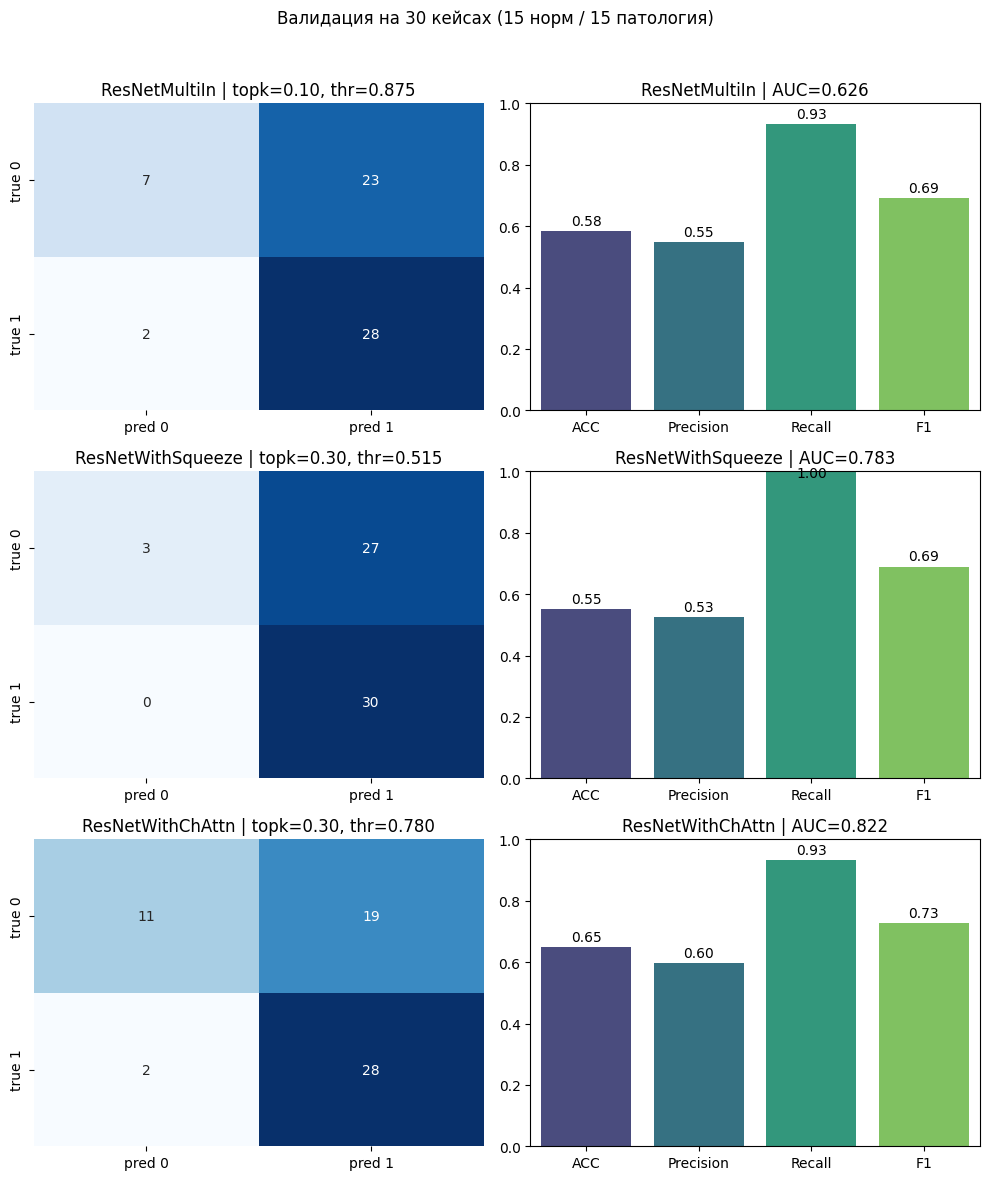

,model,topk,thr,ACC,Precision,Recall,F1,AUC,TN,FP,FN,TP
0,ResNetMultiIn,0.1,0.875,0.583333,0.549020,0.933333,0.691358,0.625556,7,23,2,28
1,ResNetWithSqueeze,0.3,0.515,0.550000,0.526316,1.000000,0.689655,0.783333,3,27,0,30
2,ResNetWithChAttn,0.3,0.780,0.650000,0.595745,0.933333,0.727273,0.822222,11,19,2,28


Saved summary: /home/mikame/Рабочий стол/CV_CT_scans/runs/exp_notebook/val30/val30_summary.csv


In [28]:
'''
# Описание: 30-кейсная валидация (CT-0 vs CT-1..4) для трёх моделей с лучшими topk/threshold
# Объекты: CONFIG (dict), build_30case_manifest(), run_inference_series()
# Функционал: собрать смесь из 30 серий (15 норм + 15 патология), прогнать инференс тремя моделями
#             с оптимальными topk/threshold, вывести визуальные confusion matrices и метрики.
# Обоснование: быстрая наглядная проверка качества на небольшой репрезентативной выборке
'''
import os, glob, random, math, sys, subprocess

# Мягкая установка зависимостей для визуализации
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
except Exception:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'matplotlib', 'seaborn'])
    import matplotlib.pyplot as plt
    import seaborn as sns

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, roc_auc_score
from torch.utils.data import DataLoader

# --- Конфигурация объектов ---
# Описание: конфиг запуска и путей, а также лучшие topk/threshold из предыдущих секций
# Обоснование: фиксируем параметры, чтобы воспроизводить одинаковые условия оценки
CONFIG = {
    'studies_root': '/home/mikame/Рабочий стол/CV_CT_scans/data/COVID19_1110/studies',
    'out_dir': '/home/mikame/Рабочий стол/CV_CT_scans/runs/exp_notebook/val30',
    'models': {
        'ResNetMultiIn':     {'factory': lambda in_ch: ResNetMultiIn(base='resnet18', in_ch=in_ch, pretrained=False), 'topk': 0.1, 'thr': 0.875, 'ckpt': '/home/mikame/Рабочий стол/CV_CT_scans/runs/exp_balanced/ResNetMultiIn/best.pt'},
        'ResNetWithSqueeze': {'factory': lambda in_ch: ResNetWithSqueeze(base='resnet18', in_ch=in_ch, squeeze_ch=3, pretrained=False), 'topk': 0.3, 'thr': 0.515, 'ckpt': '/home/mikame/Рабочий стол/CV_CT_scans/runs/exp_balanced/ResNetWithSqueeze/best.pt'},
        'ResNetWithChAttn':  {'factory': lambda in_ch: ResNetWithChAttn(base='resnet18', in_ch=in_ch, pretrained=False), 'topk': 0.3, 'thr': 0.780, 'ckpt': '/home/mikame/Рабочий стол/CV_CT_scans/runs/exp_balanced/ResNetWithChAttn/best.pt'},
    },
    'k': 5,
    'img_size': 320,
    'windows': ['lung','mediastinal'],
    'batch_size': 16,
    'workers': 8,
    'seed': 42,
}

os.makedirs(CONFIG['out_dir'], exist_ok=True)
random.seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
torch.manual_seed(CONFIG['seed'])


def build_30case_manifest(studies_root: str, out_csv: str) -> pd.DataFrame:
    '''
    # Описание: генерация 30-кейсного манифеста (15 норм, 15 патология)
    # Объект: возвращает pd.DataFrame с колонками ['study_id','path','label','split'] и сохраняет CSV
    # Функционал: случайный равновесный отбор серий из CT-0 и CT-1..4
    # Обоснование: справедливая мини-валидация с равными классами
    '''
    ct0_paths = sorted(glob.glob(os.path.join(studies_root, 'CT-0', '*.nii.gz')))
    pos_paths = []
    for grp in ['CT-1','CT-2','CT-3','CT-4']:
        pos_paths += sorted(glob.glob(os.path.join(studies_root, grp, '*.nii.gz')))
    if len(ct0_paths) < 15 or len(pos_paths) < 15:
        raise RuntimeError('Недостаточно данных для равновесной выборки 15/15.')
    ct0_sel = random.sample(ct0_paths, 30)
    pos_sel = random.sample(pos_paths, 30)
    rows = []
    for p in ct0_sel:
        sid = os.path.splitext(os.path.basename(p))[0]
        rows.append({'study_id': f'CT0::{sid}', 'path': p, 'label': 0, 'split': 'val'})
    for p in pos_sel:
        sid = os.path.splitext(os.path.basename(p))[0]
        grp = os.path.basename(os.path.dirname(p))
        rows.append({'study_id': f'{grp}::{sid}', 'path': p, 'label': 1, 'split': 'val'})
    df = pd.DataFrame(rows).sample(frac=1.0, random_state=CONFIG['seed']).reset_index(drop=True)
    df.to_csv(out_csv, index=False)
    return df

# --- Инференс серий с top-k ---
@torch.no_grad()
def run_inference_series(model: nn.Module, manifest_csv: str, pack: PackConfig, batch_size: int, workers: int, device, topk_ratio: float):
    '''
    # Описание: инференс на уровне серий с top-k агрегацией
    # Объекты: возвращает (y_true, y_prob, sids)
    # Функционал: использует CT25DDataset и eval_series из ноутбука
    # Обоснование: переиспользуем проверенные компоненты без дублирования логики
    '''
    ds = CT25DDataset(manifest_csv, split='val', pack=pack, aug=None)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, persistent_workers=(workers>0), prefetch_factor=4)
    y_true, y_prob = eval_series(model, loader, device, topk_ratio=topk_ratio)
    sids = ds.df['study_id'].tolist()
    return y_true, y_prob, sids

# --- Запуск валидации ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
manifest_30 = os.path.join(CONFIG['out_dir'], 'manifest_val30.csv')
df30 = build_30case_manifest(CONFIG['studies_root'], manifest_30)

pack = PackConfig(k=CONFIG['k'], img_size=CONFIG['img_size'], windows=CONFIG['windows'])
pack.stride_eval = 2
in_ch = len(pack.windows) * pack.k

n_models = len(CONFIG['models'])
fig, axes = plt.subplots(n_models, 2, figsize=(10, 4*n_models))
if n_models == 1:
    axes = np.array([axes])
plt.suptitle('Валидация на 30 кейсах (15 норм / 15 патология)')

summary_rows = []

for row_idx, (name, cfg) in enumerate(CONFIG['models'].items()):
    # Загрузка модели из чекпойнта
    model = cfg['factory'](in_ch).to(DEVICE)
    ckpt_path = cfg['ckpt']
    if not os.path.isfile(ckpt_path):
        alt = ckpt_path.replace('/runs/exp_balanced/', '/runs Done/exp_balanced/')
        ckpt_path = alt if os.path.isfile(alt) else ckpt_path
    state = torch.load(ckpt_path, map_location='cpu')
    model.load_state_dict(state['model'], strict=True)
    model.eval()

    # Инференс и метрики
    y_true, y_prob, sids = run_inference_series(model, manifest_30, pack, CONFIG['batch_size'], CONFIG['workers'], DEVICE, topk_ratio=cfg['topk'])
    y_pred = (y_prob >= cfg['thr']).astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    prec = tp / max(1, (tp + fp))
    rec = tp / max(1, (tp + fn))
    f1 = (2*prec*rec) / max(1e-8, (prec + rec))
    try:
        auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else float('nan')
    except Exception:
        auc = float('nan')

    # Визуализация: Confusion Matrix + бары метрик
    ax_cm = axes[row_idx, 0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax_cm,
                xticklabels=['pred 0','pred 1'], yticklabels=['true 0','true 1'])
    ax_cm.set_title(f'{name} | topk={cfg["topk"]:.2f}, thr={cfg["thr"]:.3f}')

    ax_bar = axes[row_idx, 1]
    metrics = ['ACC','Precision','Recall','F1']
    values = [acc, prec, rec, f1]
    sns.barplot(x=metrics, y=values, palette='viridis', ax=ax_bar)
    ax_bar.set_ylim(0,1)
    for i,v in enumerate(values):
        ax_bar.text(i, min(0.98, v+0.02), f'{v:.2f}', ha='center')
    ax_bar.set_title(f'{name} | AUC={auc:.3f}')

    summary_rows.append({'model': name, 'topk': cfg['topk'], 'thr': cfg['thr'], 'ACC': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'AUC': auc,
                         'TN': int(tn), 'FP': int(fp), 'FN': int(fn), 'TP': int(tp)})

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# Сводная таблица и сохранение
summary_df = pd.DataFrame(summary_rows)
summary_csv = os.path.join(CONFIG['out_dir'], 'val30_summary.csv')
summary_df.to_csv(summary_csv, index=False)
display(summary_df)
print('Saved summary:', summary_csv)

